In [1]:
from dask.distributed import Client, LocalCluster
# import geopandas as gpd
# import networkx as nx
# from itertools import combinations
import dask
import numpy as np
from dask import delayed, dataframe as dd
import dask.array as da
import bokeh
import geopandas as gpd
from dask_ml.cluster import KMeans
import dask_geopandas as dgpd
from tqdm.notebook import tqdm
import pandas as pd
import json
import os
import glob

/tmp/ipykernel_4113/1182815297.py:10: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
tessellation = gpd.read_parquet("./out/singapore/tessellation.pq")

In [3]:
def duplicates(tessellation):
    # Check for duplicates based on UID
    duplicates = tessellation[tessellation.duplicated(subset='uID', keep=False)]

    # duplicates.to_file( "./out/" + place + 'errors.shp', driver='ESRI Shapefile')

    # Print the duplicate rows
    if len(duplicates) > 0:
        raise Exception("Tesselation: Duplicate UID entries:")
    elif (tessellation["uID"].isnull().values.any()):
        raise Exception("uID column include invalid entries")
    else:
        return 0

duplicates(tessellation)

0

In [4]:
# Init graph object
# G = nx.Graph()

In [5]:
# uID_list = tessellation["uID"].unique()

# for uid in np.sort(uID_list):
#     G.add_node(uid)

In [6]:
# Load the tessellation as a Dask dataframe
# tessellation_dd = dd.from_pandas(tessellation, npartitions=24)

In [7]:
# # define a function to process every pair
# def process_pair(pair):
#     # do something with the pair of rows

#     out = (int(pair[0]["uID"]), int(pair[1]["uID"]))
#     print(out)
#     return out
#     # if x_geom.touches(y_geom):
#     #     G.add_edge(pair[0]["uID"], pair[1]["uID"])
#     # elif x_geom.intersects(y_geom):
#     #     G.add_edge(pair[0]["uID"], pair[1]["uID"])

# pairs = []

# # iterate through every pair of rows in the Dask dataframe
# pairs = tessellation_dd.compute().index.tolist()
# for i, j in combinations(pairs, 2):
#     # get the rows of the two indices
#     row1 = tessellation_dd.loc[i].compute()
#     row2 = tessellation_dd.loc[j].compute()

#     # do something with the pair of geometries
#     pair = process_pair((row1, row2))
    
#     # append the pair to the list
#     pairs.append(pair)

In [8]:
Daskcluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='24GB')

client = Client(Daskcluster)
client

2023-03-22 00:19:12,023 - distributed.worker_memory - WARNING - Ignoring provided memory limit 24GB due to system memory limit of 15.58 GiB
2023-03-22 00:19:12,027 - distributed.worker_memory - WARNING - Ignoring provided memory limit 24GB due to system memory limit of 15.58 GiB
2023-03-22 00:19:12,031 - distributed.worker_memory - WARNING - Ignoring provided memory limit 24GB due to system memory limit of 15.58 GiB
2023-03-22 00:19:12,035 - distributed.worker_memory - WARNING - Ignoring provided memory limit 24GB due to system memory limit of 15.58 GiB
2023-03-22 00:19:12,038 - distributed.worker_memory - WARNING - Ignoring provided memory limit 24GB due to system memory limit of 15.58 GiB
2023-03-22 00:19:12,042 - distributed.worker_memory - WARNING - Ignoring provided memory limit 24GB due to system memory limit of 15.58 GiB
2023-03-22 00:19:12,046 - distributed.worker_memory - WARNING - Ignoring provided memory limit 24GB due to system memory limit of 15.58 GiB
2023-03-22 00:19:12,

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 124.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42981,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 124.66 GiB
Comm: tcp://127.0.0.1:45785,Total threads: 2
Dashboard: http://127.0.0.1:39031/status,Memory: 15.58 GiB
Nanny: tcp://127.0.0.1:42283,


In [9]:
# Assuming 'tessellation' is a GeoDataFrame with a 'geometry' column
# Convert the GeoDataFrame to a Dask GeoDataFrame
dask_tessellation = dd.from_pandas(tessellation, npartitions=16)

In [10]:
print(dask_tessellation)

Dask GeoDataFrame Structure:
                    uID  geometry    eID
npartitions=16                          
0               float64  geometry  int64
7275                ...       ...    ...
...                 ...       ...    ...
109120              ...       ...    ...
116393              ...       ...    ...
Dask Name: from_pandas, 1 graph layer


In [11]:
x_coords = dask_tessellation.geometry.centroid.x.to_dask_array(lengths=True)
y_coords = dask_tessellation.geometry.centroid.y.to_dask_array(lengths=True)

# Concatenate x and y coordinates along the second axis
coords = da.concatenate([x_coords[:, None], y_coords[:, None]], axis=1)

# Rechunk the coords array along the first axis only
coords = coords.rechunk({0: -1, 1: coords.shape[1]})

print(coords.compute())

/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:71: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  return pickle.loads(x, buffers=buffers)
/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:71: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPan

[[18696.32446303 36759.53594173]
 [13828.67894722 35579.87920014]
 [34107.38595297 39189.54808547]
 ...
 [39426.06555894 39298.45027431]
 [40120.13501936 38056.07838077]
 [40116.47064341 38065.09842334]]


In [12]:
n_clusters = int(len(tessellation) / 2500) # compute the number of clusters needed
print(n_clusters)

46


In [13]:
# Train the KMeans estimator with 100 clusters
kmeans = KMeans(n_clusters)

# Fit the KMeans estimator to the data
kmeans.fit(coords)


/home/virgilxw/miniconda3/lib/python3.10/site-packages/dask/base.py:1367: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/virgilxw/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=46)

In [14]:
# Predict the clusters of the data points
labels = kmeans.predict(coords)

labels_np = labels.compute()

tessellation["cluster"] = labels_np

<Axes: >

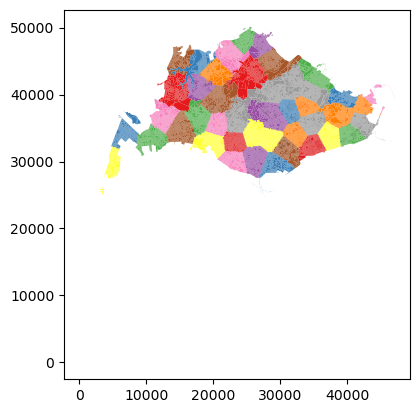

In [15]:
# Specify the column to use for color and colormap
column = 'cluster'
cmap = 'Set1'

# Plot the GeoDataFrame with colors determined by the 'cluster' column
tessellation.plot(column=column, cmap=cmap)

In [16]:
duplicates(tessellation)

0

In [17]:
# Assume `gdf` is a GeoDataFrame
tessellation_grouped = tessellation.groupby('cluster')

# Create a dictionary of separate GeoDataFrames, one for each group
tessellation_separate = dict()
for group_name, group in tessellation_grouped:
    tessellation_separate[group_name] = group

In [18]:
dask_tessellation = dgpd.from_geopandas(tessellation, npartitions=16)

dask_tessellation = dask_tessellation.dissolve(by='cluster')
cluster = dask_tessellation.compute()

<Axes: >

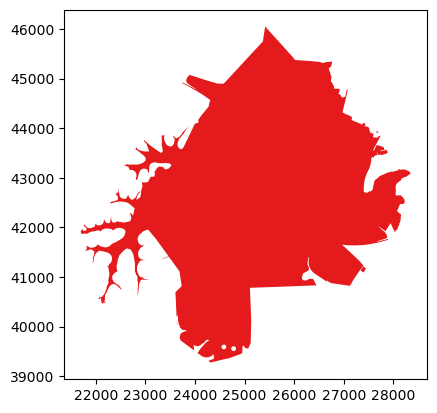

In [19]:

# Specify the column to use for color and colormap
column = 'cluster'
cmap = 'Set1'

# Plot the GeoDataFrame with colors determined by the 'cluster' column
cluster.loc[[2]].plot(cmap=cmap)

In [20]:
Daskcluster.close()
client.shutdown()

In [21]:
cluster.to_parquet("./out/singapore/clusters.pq")

In [22]:
file_pattern = "./out/singapore/tess_chunk_*.pq"
file_list = glob.glob(file_pattern)

for file_path in file_list:
    os.remove(file_path)

for key in tessellation_separate:
    out = tessellation_separate[key]
    print(duplicates(out))
    print(out)
    out.to_parquet("./out/singapore/tess_chunk_"+str(key)+".pq")

0
              uID                                           geometry    eID  \
157         162.0  MULTIPOLYGON (((36184.762 31507.534, 36183.428...     27   
158         163.0  POLYGON ((36093.208 31517.599, 36093.186 31517...     27   
159         164.0  POLYGON ((35993.787 31655.484, 35999.150 31648...     27   
160         165.0  POLYGON ((35929.027 31955.352, 35928.468 31956...   4333   
175         180.0  POLYGON ((35822.679 31913.627, 35825.312 31908...   4333   
...           ...                                                ...    ...   
116145  5011161.0  POLYGON ((34267.033 32325.190, 34269.027 32317...  14634   
116146  5011162.0  POLYGON ((34291.861 32321.748, 34289.960 32329...  14635   
116233  5011249.0  POLYGON ((32931.801 31300.997, 32937.761 31303...  14744   
116234  5011250.0  POLYGON ((32937.761 31303.343, 32931.801 31300...  14745   
116235  5011251.0  POLYGON ((32906.234 31192.258, 32901.042 31190...  14746   

        cluster  
157           0  
158          

In [23]:
includes_dict = dict()
for i in range(n_clusters):
    includes_dict[i] = []

for index, row in tqdm(tessellation.iterrows(), total=tessellation.shape[0]):
    includes_dict[row["cluster"]].append(row["uID"])

with open('./out/singapore/clustertess.json', 'w') as f:
    json.dump(includes_dict, f)

  0%|          | 0/116394 [00:00<?, ?it/s]

2023-03-22 00:25:47,293 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
